# THERBシミュレーションデータ分析  

THERBによる熱負荷シミュレーションの結果をJupyter Notebookを使って分析していきます。  

# 章構成  
[Tutorial 0&1. THERBの結果を分析してみる](#section_0)  
[Tutorial 2. 窓を変えてみる](#section_1)  
[Tutorial 3. 庇データを変えてみる](#section_2)  
[Tutorial 4. 方位角を変えてみる](#section_3)  
[Tutorial 5. 換気量を変えてみる](#section_4)  
[Tutorial 6. 壁体構成を変えてみる](#section_6)  
[Tutorial 7. 空調負荷を計算してみる](#section_7)  

まずはPythonライブラリをimportします

In [4]:
import requests
import json
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [3]:
! pip install openpyxl

<a id='section_0'></a>  
## Tutorial 0. THERBの結果を分析してみる

### 結果データを取得する

In [85]:
def getResultData(id):
    try:
        response = requests.get(f'https://oyster-app-8jboe.ondigitalocean.app/therb/{id}')
        #response = requests.get(f'http://localhost:5000/therb/{id}')
        data = json.loads(response.text)
        
        #jsonデータをpandasのdataframeに変換する
        return data['data']
    except:
        throw('no id matches data in database')

getResultDataに渡すidはtherb-frontendのUIのここから取得できます
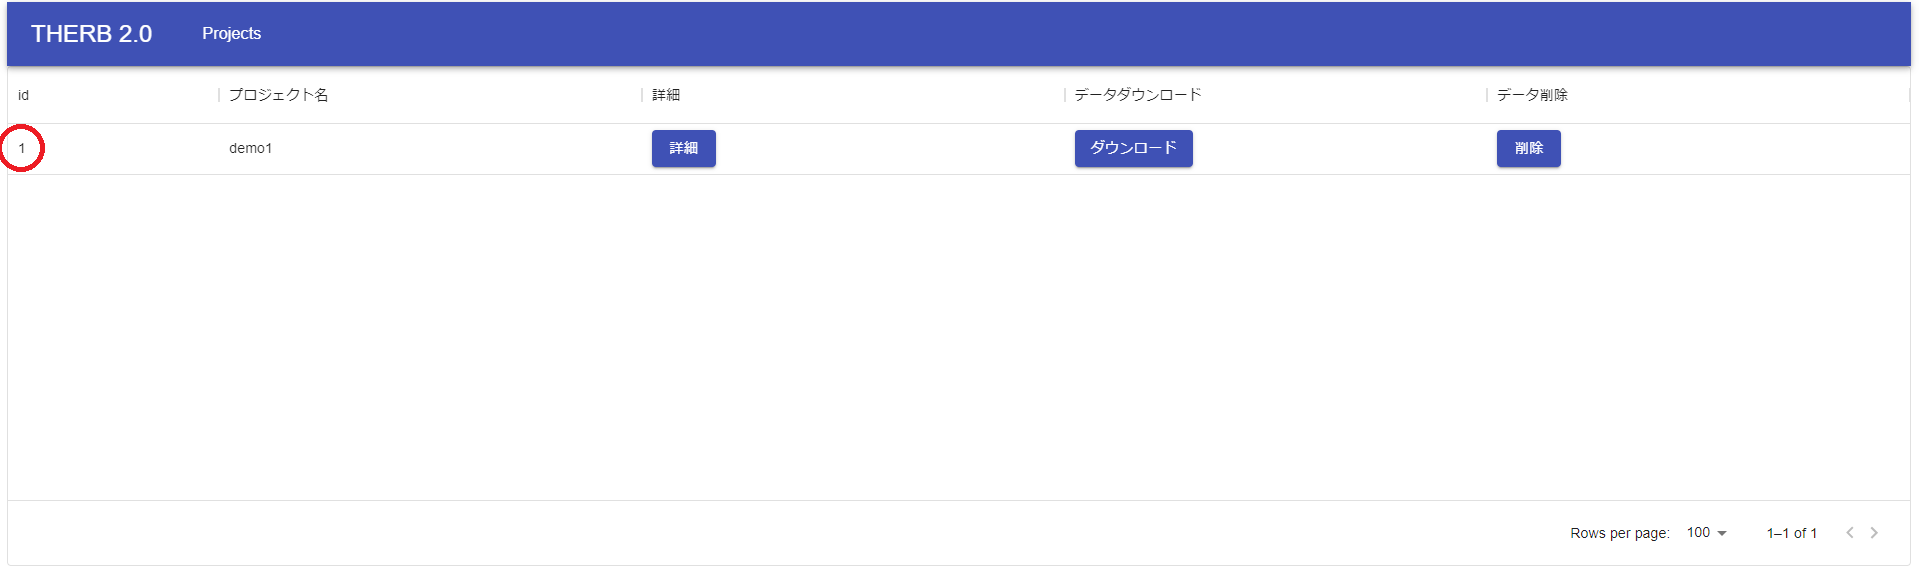

In [86]:
rawDataList = getResultData(15)

部屋ごとにデータを整理できるようにする必要

In [87]:
def convertToDataframe(resultDict):
    columns = []
    rows = []
    for k,v in resultDict.items():
        columns.append(k)
        rows.append(v)
    
    #transposedRows = np.array(rows,dtype=np.float32).T
    transposedRows = np.array(rows).T
    
    df = pd.DataFrame(data = transposedRows, columns = columns) 
    df=df.set_index('time')
    #df.to_excel("test.xlsx")
    #return df
    df=df.astype('float32')
    return df

In [88]:
def dataFrameByKey(resultDataList,columnName):
    tempData = []
    columns=[]
    for resultData in resultDataList:
        df = convertToDataframe(resultData["results"])
        try:
            tempData.append(df[columnName])
            columns.append(resultData["roomId"])
        except:
            pass
    df=pd.concat(tempData,axis=1)
    df.columns = columns
    return df

In [89]:
df=dataFrameByKey(rawDataList,"temp")

In [90]:
df

,outdoor,room1
time,,
01/05/24:00,8.4,9.62
01/06/01:00,8.4,9.63
01/06/02:00,8.3,9.59
01/06/03:00,8.3,9.57
01/06/04:00,8.2,9.55
...,...,...
12/26/20:00,10.4,10.71
12/26/21:00,9.7,10.68
12/26/22:00,9.3,10.65


### 結果表示してみる

In [190]:
def plotDf(df,startTime,endTime,minTemp=18,maxTemp=28):
    ax=df[startTime:endTime].plot(figsize=(20,10))
    ax.set_ylabel("Temperature[degC]")
    ax.axhline(y=minTemp, color='blue')
    ax.text(0, minTemp+1, "Lower limit[degC]", fontsize="large")
    ax.axhline(y=maxTemp, color='red')
    ax.text(0, maxTemp+1, "Upper limit[degC]", fontsize="large")

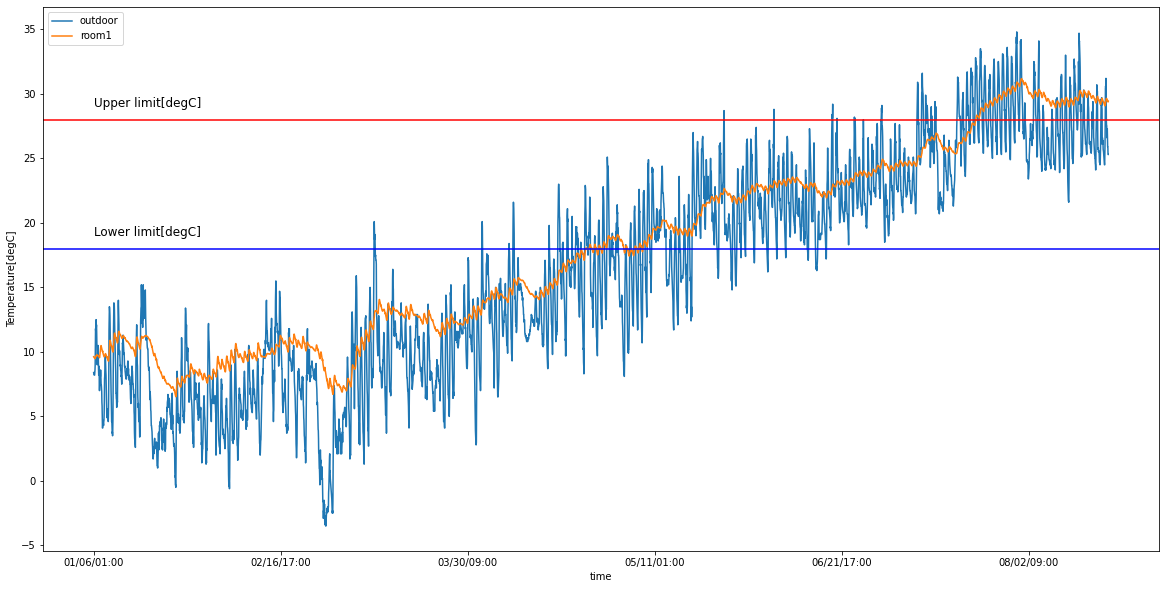

In [178]:
plotDf(df,"01/06/01:00","08/20/01:00",18,28)

### 自然室温で快適時間の割合は？

In [91]:
def calcPercentage(data,min,max):
    maxSatisfied = data[lambda x: x<max]
    satisfied = maxSatisfied[lambda x: x>min]
    percentage = len(satisfied)/len(data)*100
    return round(percentage,1)

In [92]:
def comfortTimePercentage(df,min,max):
    comfortTimeDict = {
        "min":min,
        "max":max,
        "hours":len(df)
    }
    for col in df.columns:
        newCol = f'{col}_comfort_perentage[%]'
        comfortTimeDict[newCol]=calcPercentage(df[col],min,max)
    #calculate room average
    roomDataList =list(comfortTimeDict.values())[4:]
    average =sum(roomDataList)/len(roomDataList)
    comfortTimeDict["average[%]"]=average
    
    return comfortTimeDict

In [179]:
comfortTimeDict=comfortTimePercentage(df,18,28)

In [94]:
comfortTimeDict

{'min': 20,
 'max': 28,
 'hours': 8521,
 'outdoor_comfort_perentage[%]': 32.6,
 'room1_comfort_perentage[%]': 34.8,
 'average[%]': 34.8}

### 今後のtutorialの結果は以下快適時間の割合でも比較していきます

In [110]:
def getKpiData():
    try:
        response = requests.get(f'https://oyster-app-8jboe.ondigitalocean.app/kpis')
        #response = requests.get(f'http://localhost:5000/therb/{id}')
        data = json.loads(response.text)
        
        return data['data']
    except:
        throw('no id matches data in database')

In [186]:
kpiResult=getKpiData()

In [197]:
kpiResult

[{'comfortTime': {'average[%]': 46.7,
   'hours': 8521,
   'max': 28,
   'min': 18,
   'outdoor_comfort_perentage[%]': 40.0,
   'room1_comfort_perentage[%]': 46.7},
  'heatLoad': {},
  'id': 1,
  'project_id': 15},
 {'comfortTime': {'average[%]': 45.3,
   'hours': 8521,
   'max': 28,
   'min': 18,
   'outdoor_comfort_perentage[%]': 40.0,
   'room1_comfort_perentage[%]': 45.3},
  'heatLoad': {},
  'id': 2,
  'project_id': 16}]

In [159]:
def plotKpiRanking(kpiResult):
    import math
    ranking={}
    for kpi in kpiResult:
        ranking[f'id_{kpi["project_id"]}']=kpi["comfortTime"]["average[%]"]
        
    #昇順に並び替える
    ordered={k: v for k, v in sorted(ranking.items(), key=lambda item: item[1],reverse=True)}
    plt.bar(ordered.keys(), ordered.values(), color ='forestgreen',
        width = 0.4)
    plt.xlabel("project id")
    plt.ylabel("comfortable time[%]")
    plt.ylim(30,math.ceil(list(ordered.values())[0]))
    return ordered

{'id_15': 46.7, 'id_16': 45.3}

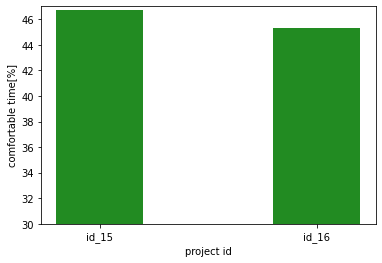

In [188]:
plotKpiRanking(kpiResult)

## 作業中（ここはとばして[Tutorial2](#section_1)  にとんでください）

In [17]:
def makeHourlyData(df):
    dfDict={}
    df["hour"]=df.index.to_series().apply(lambda x: x.split('/')[2])
    grouped=df.groupby("hour")
    for name,group in grouped:
        #dfList.append(group.drop('month', axis=1))
        dfDict[name]=group.drop('hour', axis=1)
    return dfDict

In [18]:
hourlyDict=makeHourlyData(df)

In [19]:
hourlyDict

{'01:00':              outdoor  room1  room2  room3
 time                                     
 01/06/01:00      8.4   7.51   7.82   7.57
 01/07/01:00     10.2   8.67   9.06   9.14
 01/08/01:00      4.1   7.29   7.45   7.19
 01/09/01:00      5.2   6.68   6.52   6.54
 01/10/01:00      4.6   7.90   8.51   8.15
 ...              ...    ...    ...    ...
 12/27/01:00      8.2   9.60  10.21  10.27
 12/28/01:00      6.0   8.55   8.69   8.61
 12/29/01:00      4.7   8.15   8.42   7.95
 12/30/01:00      5.3   7.56   7.76   7.38
 12/31/01:00     15.1  10.47  11.25  11.20
 
 [360 rows x 4 columns],
 '02:00':              outdoor  room1  room2  room3
 time                                     
 01/06/02:00      8.3   7.47   7.75   7.55
 01/07/02:00      9.3   8.64   9.02   9.11
 01/08/02:00      4.7   7.03   7.12   6.89
 01/09/02:00      5.2   6.50   6.31   6.35
 01/10/02:00      4.7   7.58   8.10   7.82
 ...              ...    ...    ...    ...
 12/27/02:00      8.4   9.43   9.99  10.06
 12/28/02

In [24]:
def hourlyBoxPlot(dfDict):
    fig = plt.figure(figsize=(20,30))
    i=1
    for name,df in dfDict.items():
        ax = fig.add_subplot(6,4,i)
        df.boxplot(ax=ax)
        ax.set_title(name)
        i+=1

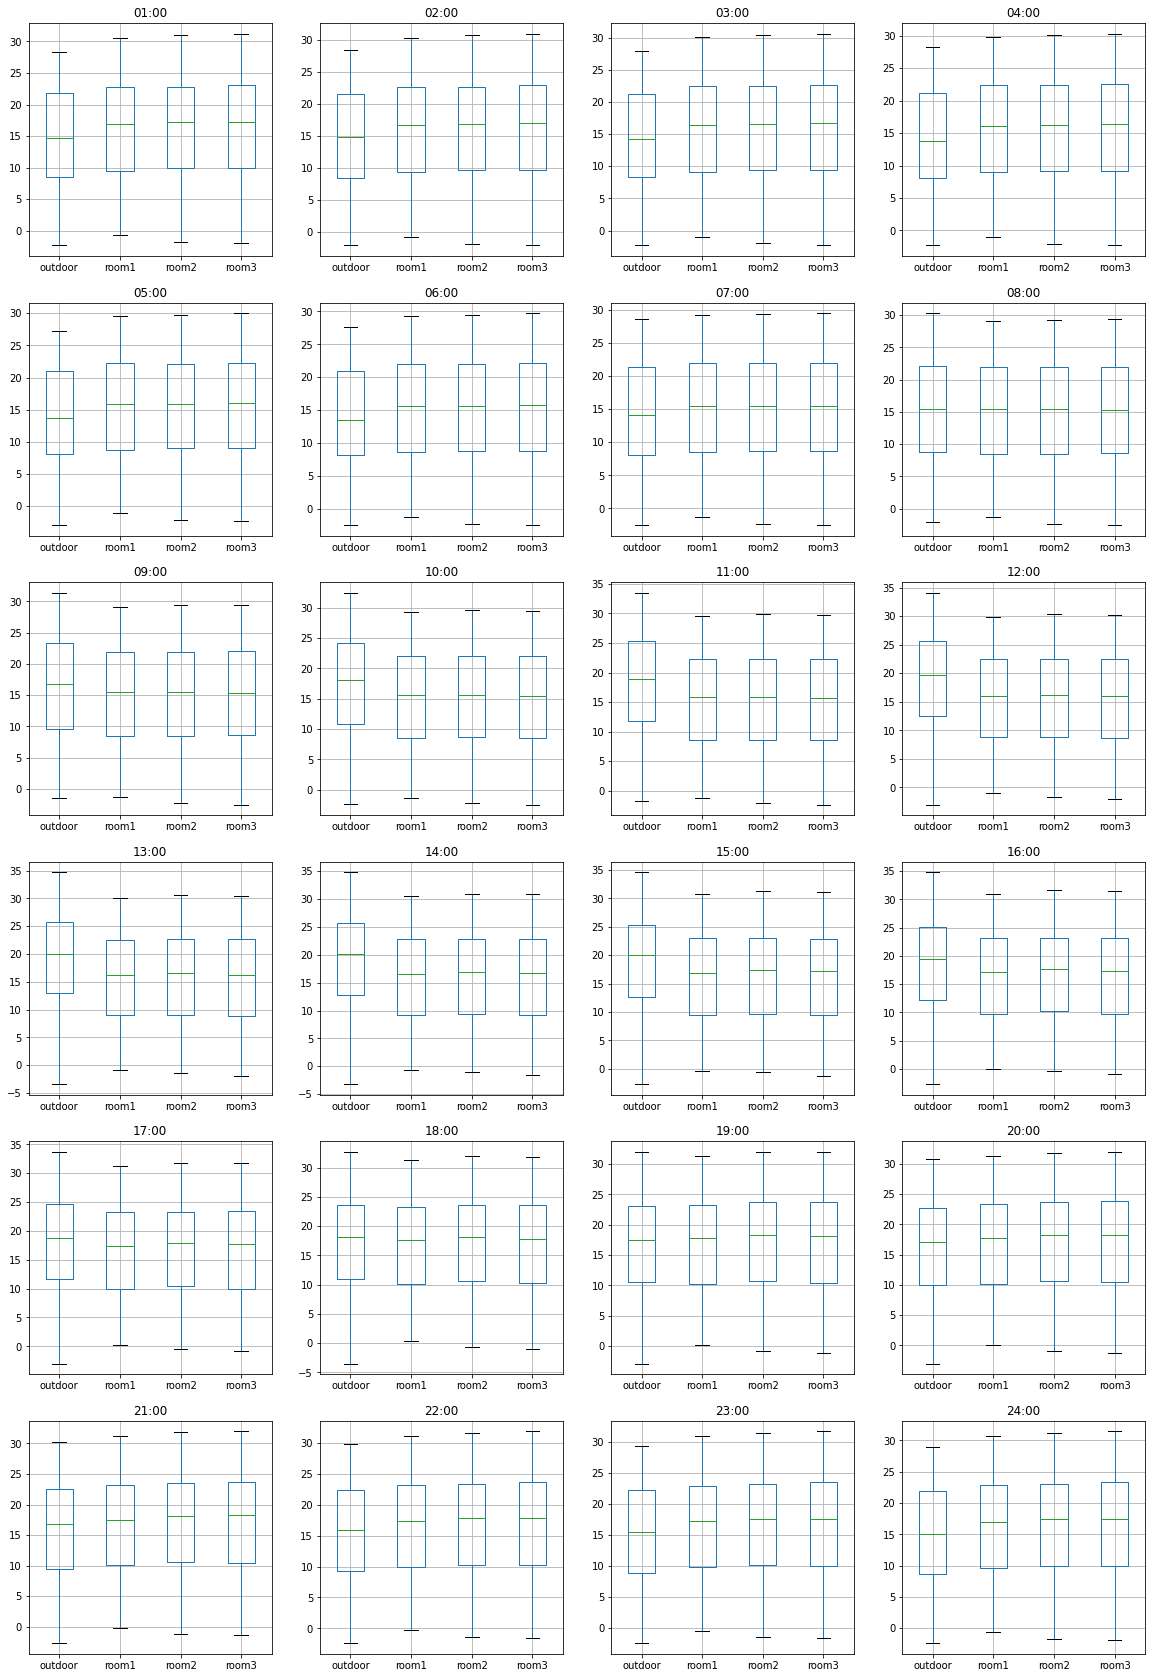

In [25]:
hourlyBoxPlot(hourlyDict)

### ↑　コンクリートの熱容量が効いてるような挙動が見られる

In [133]:
import matplotlib.pyplot as plt

### 月足チャートを作成して、outdoor,room1,room2のデータを比較してみる

# TODO: y軸を揃えられるようにする

In [115]:
df["month"]=df.index.to_series().apply(lambda x: x.split('/')[0])

In [193]:
def makeMonthlyData(df):
    #df=pd.DataFrame(seriesData)
    dfDict={}
    df["month"]=df.index.to_series().apply(lambda x: x.split('/')[0])
    grouped=df.groupby("month")
    for name,group in grouped:
        #dfList.append(group.drop('month', axis=1))
        dfDict[name]=group.drop('month', axis=1)
    return dfDict

In [191]:
monthlyDf=makeMonthlyData(df)

01
02
03
04
05
06
07
08
09
10
11
12


In [186]:
def monthlyBoxPlot(dfDict):
    fig = plt.figure(figsize=(20,10))
    title_dict = {
        1:'January',
        2:'February',
        3:'March',
        4:'April',
        5:'May',
        6:'June',
        7:'July',
        8:'August',
        9:'September',
        10:'October',
        11:'November',
        12:'December',
    }
    i=1
    for df in dfDict.values():
        ax = fig.add_subplot(3,4,i)
        df.boxplot(ax=ax)
        ax.set_title(title_dict[i])
        i+=1

01
02
03
04
05
06
07
08
09
10
11
12


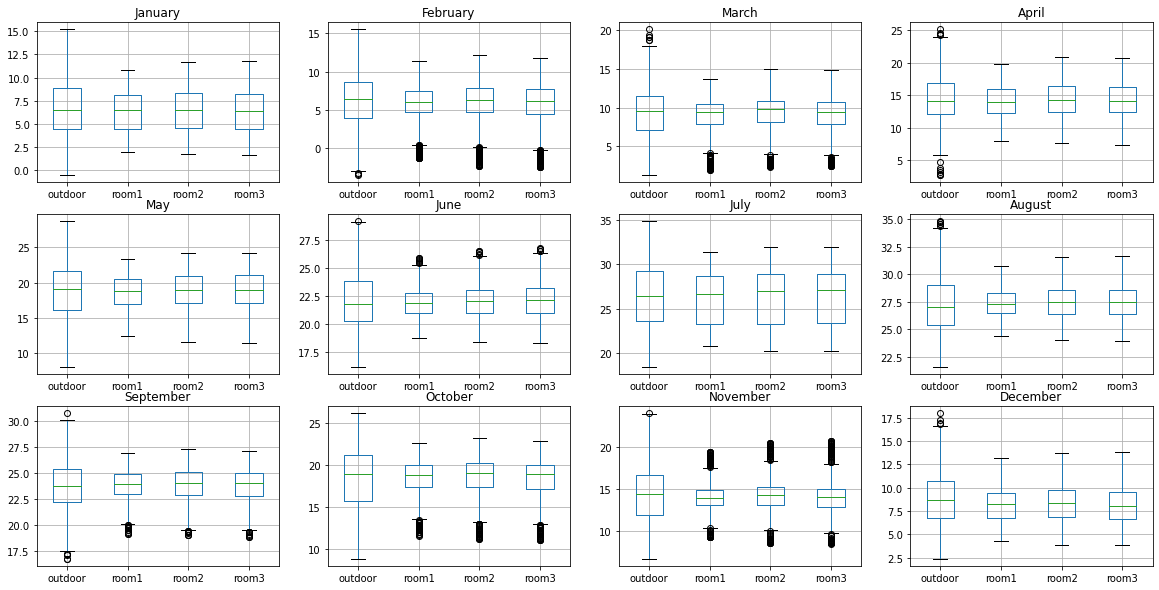

In [192]:
monthlyBoxPlot(makeMonthlyData(df))

↑　外気温度に対して室内温度が緩やかになっていることがわかる

In [167]:
monthlyDf=makeMonthlyData(df)

In [198]:
monthlyDf["01"].describe()

,outdoor,room1,room2,room3
count,625.000000,625.000000,625.000000,625.000000
mean,6.928000,6.372640,6.499056,6.357952
std,3.232656,2.085778,2.364723,2.353794
min,-0.500000,2.000000,1.790000,1.690000
25%,4.500000,4.490000,4.540000,4.490000
50%,6.500000,6.460000,6.550000,6.350000
75%,8.900000,8.070000,8.390000,8.220000
max,15.200000,10.860000,11.640000,11.790000


In [201]:
monthlyDf["08"].describe()

,outdoor,room1,room2,room3
count,744.000000,744.000000,744.000000,744.000000
mean,27.367071,27.386829,27.550377,27.547783
std,2.523265,1.251765,1.484473,1.494805
min,21.600000,24.430000,24.030001,23.969999
25%,25.400000,26.437500,26.425000,26.415000
50%,27.000000,27.330000,27.505000,27.495000
75%,29.000000,28.272501,28.549999,28.549999
max,34.799999,30.740000,31.559999,31.610001


<AxesSubplot:>

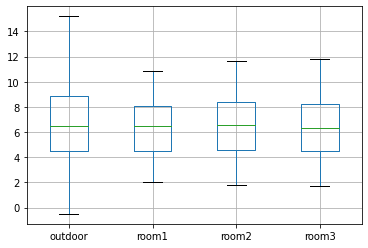

In [200]:
monthlyDf["01"].boxplot()

↑　25%,50%,75%はあまり変わっていない。std(分散)が低くなっているので室温安定性が上がっている=>熱容量の効果  
最高室温がroom1が1度弱他の室と比べて低い=>窓がないためと思われる

## 時間ごとのデータに分ける

<AxesSubplot:xlabel='time'>

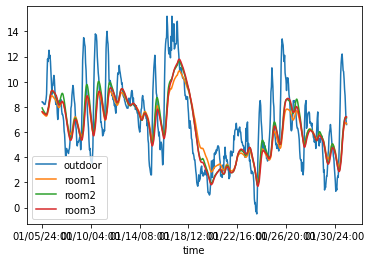

In [199]:
monthlyDf["01"].plot()

In [203]:
monthlyDf["01"]

,outdoor,room1,room2,room3
time,,,,
01/05/24:00,8.4,7.59,7.92,7.63
01/06/01:00,8.4,7.51,7.82,7.57
01/06/02:00,8.3,7.47,7.75,7.55
01/06/03:00,8.3,7.43,7.68,7.51
01/06/04:00,8.2,7.39,7.61,7.48
...,...,...,...,...
01/31/20:00,9.4,6.62,7.02,6.92
01/31/21:00,8.9,6.71,7.14,7.09
01/31/22:00,7.9,6.75,7.20,7.20


In [196]:
def plotHist(dfDict,month):
    cols=dfDict[month].columns
    results={}
    for col in cols:
        dfDict[month][col].hist(histtype='step')
        temp={}
        temp["median"] = dfDict[month][col].median()
        temp["mean"] = dfDict[month][col].mean()
        #legendが欲しい

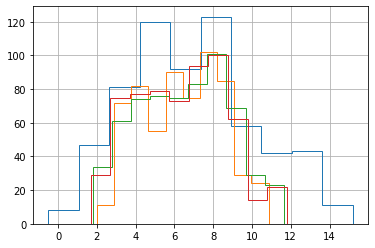

In [197]:
plotHist(monthlyDf,"01")

## ヒストグラムで比較する

In [128]:
test=makeMonthlyChart(df)

             outdoor  room1  room2  room3
time                                     
01/05/24:00      8.4   7.59   7.92   7.63
01/06/01:00      8.4   7.51   7.82   7.57
01/06/02:00      8.3   7.47   7.75   7.55
01/06/03:00      8.3   7.43   7.68   7.51
01/06/04:00      8.2   7.39   7.61   7.48
...              ...    ...    ...    ...
01/31/20:00      9.4   6.62   7.02   6.92
01/31/21:00      8.9   6.71   7.14   7.09
01/31/22:00      7.9   6.75   7.20   7.20
01/31/23:00      6.9   6.73   7.19   7.23
01/31/24:00      6.6   6.66   7.13   7.20

[625 rows x 4 columns]
             outdoor  room1  room2  room3
time                                     
02/01/01:00      6.1   6.58   7.05   7.16
02/01/02:00      5.8   6.46   6.92   7.04
02/01/03:00      5.6   6.32   6.77   6.91
02/01/04:00      5.4   6.19   6.61   6.76
02/01/05:00      5.1   6.05   6.44   6.60
...              ...    ...    ...    ...
02/28/20:00      4.3   2.86   3.99   3.13
02/28/21:00      3.5   2.87   3.98   3.24
02/28/22:0

## 1月、8月の温度がマイルドになればよい => ヒストグラムで表示する

In [120]:
test

,room1,month
time,,
01/05/24:00,7.59,01
01/06/01:00,7.51,01
01/06/02:00,7.47,01
01/06/03:00,7.43,01
01/06/04:00,7.39,01
...,...,...
12/31/20:00,9.57,12
12/31/21:00,9.46,12
12/31/22:00,9.34,12


<a id='section_1'></a>
# Tutorial2. 窓を変えてみる

### データを取得し、前処理を行う

In [95]:
t2List = getResultData(13)
t2df=dataFrameByKey(t2List,"temp")

In [100]:
t2List2 = getResultData(14)
t2df2=dataFrameByKey(t2List2,"temp")

In [98]:
t2df

,outdoor,room1
time,,
01/05/24:00,8.4,9.62
01/06/01:00,8.4,9.63
01/06/02:00,8.3,9.59
01/06/03:00,8.3,9.57
01/06/04:00,8.2,9.55
...,...,...
12/26/20:00,10.4,10.71
12/26/21:00,9.7,10.68
12/26/22:00,9.3,10.65


In [101]:
t2df2

,outdoor,room1
time,,
01/05/24:00,8.4,9.71
01/06/01:00,8.4,9.71
01/06/02:00,8.3,9.67
01/06/03:00,8.3,9.63
01/06/04:00,8.2,9.60
...,...,...
12/26/20:00,10.4,10.55
12/26/21:00,9.7,10.51
12/26/22:00,9.3,10.48


In [102]:
test = pd.DataFrame([t2df["room1"],t2df2["room1"]]).T

In [103]:
test.columns=["before","after"]

## 南面だけに窓を配置した場合(before)と、南、東、西に窓を配置した場合(after)で結果を比較する

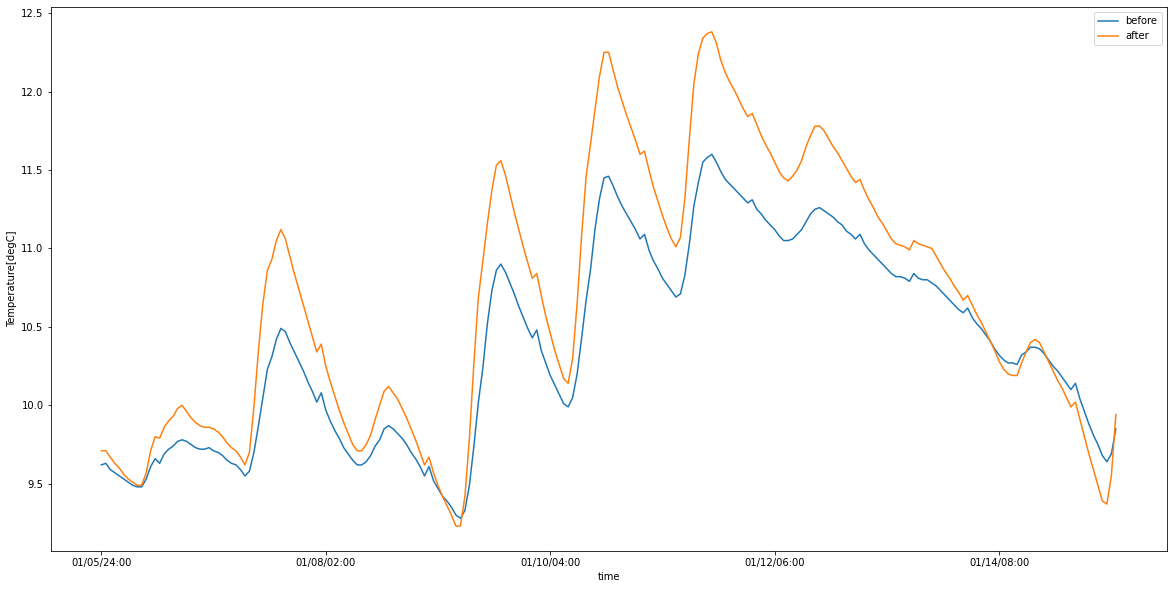

In [107]:
plotDf(test,"01/01/10:00","01/15/10:00")

<a id='section_2'></a>
# Tutorial3. 庇をつけてみる（スキップ）

In [34]:
t2List = getResultData(18)
t2df=dataFrameByKey(t2List,"temp")

In [44]:
t2afterList = getResultData(21)
t2afterdf=dataFrameByKey(t2afterList,"temp")

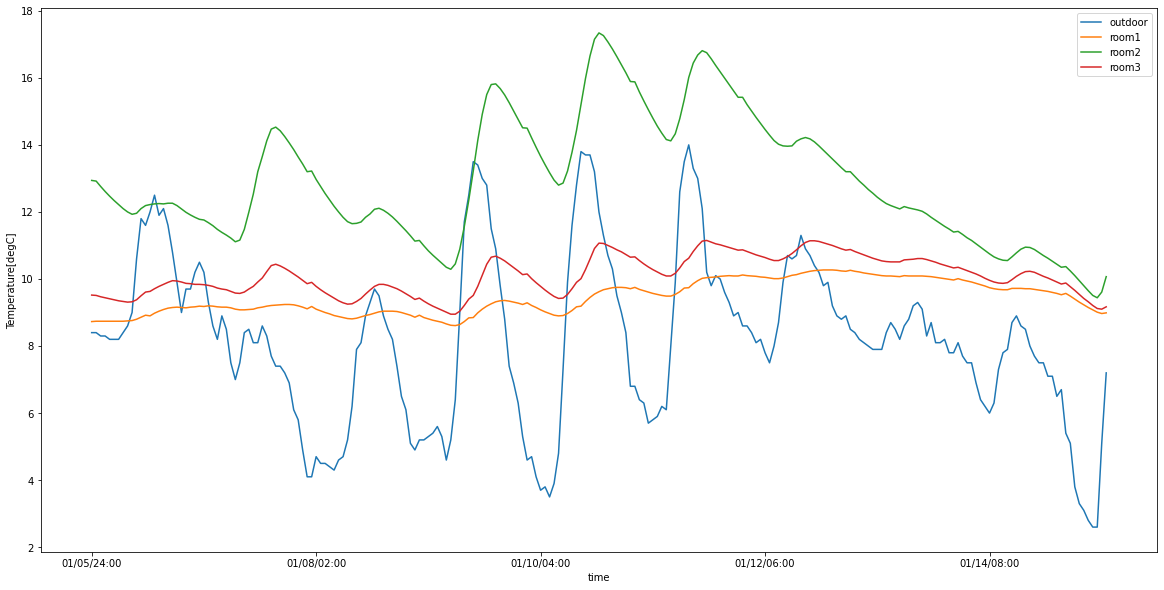

In [36]:
plotDf(t2df,"01/01/10:00","01/15/10:00")

In [45]:
test = pd.DataFrame([t2df["room2"],t2afterdf["room2"]]).T
test.columns=["withoutShading","withShading"]

In [46]:
test["diff"]=test["withoutShading"]-test["withShading"]

<AxesSubplot:xlabel='time'>

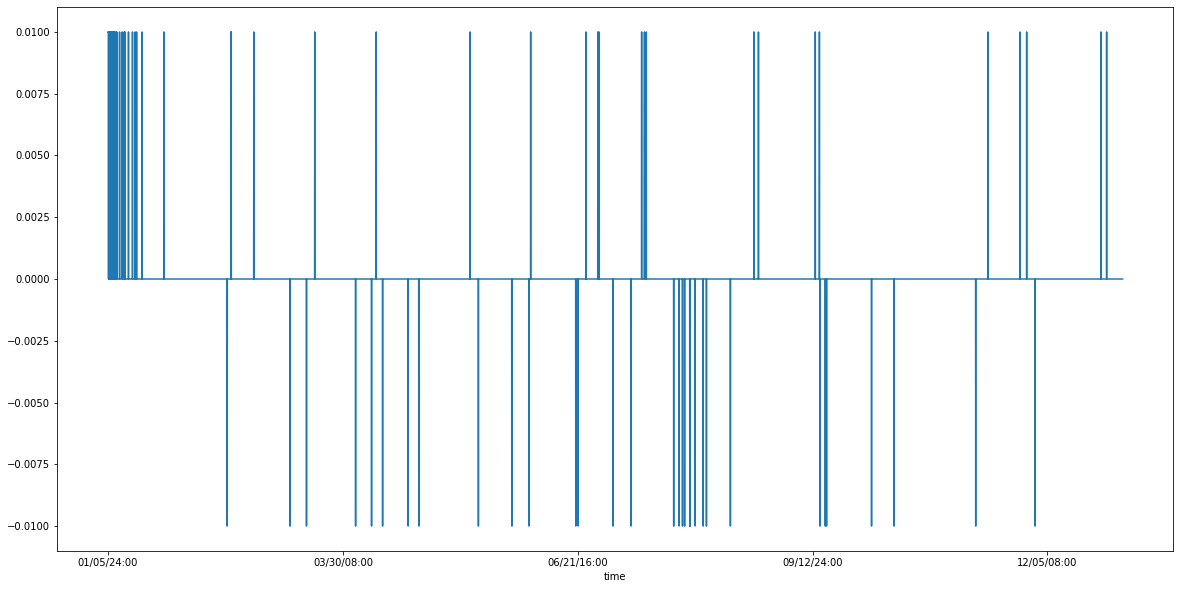

In [47]:
test["diff"].plot(figsize=(20,10))

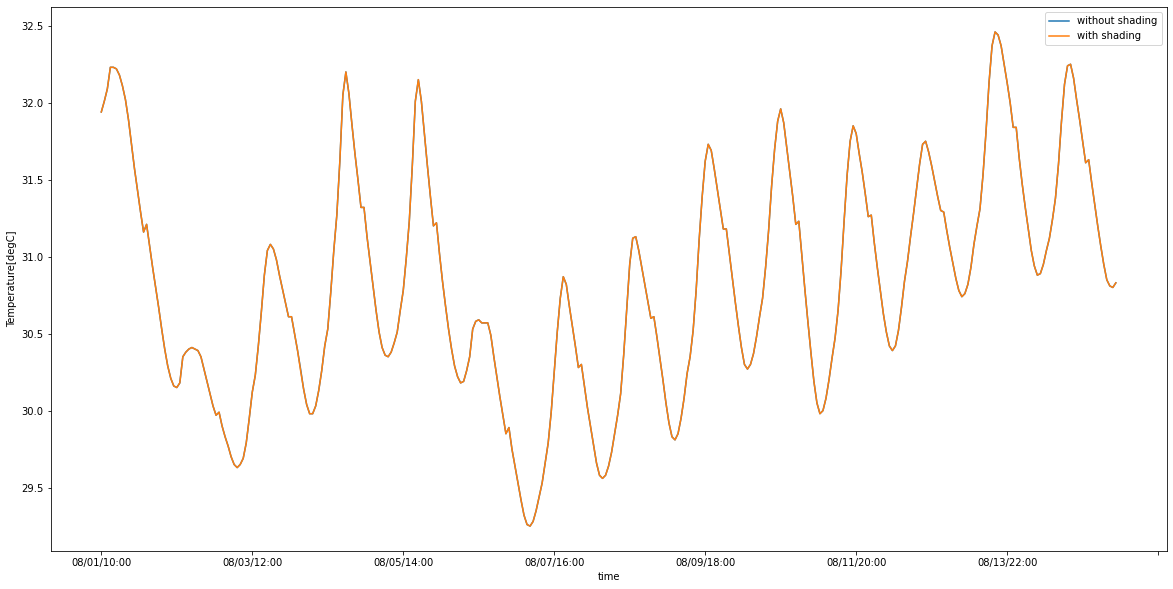

In [29]:
plotDf(test,"08/01/10:00","08/15/10:00")

<a id='section_3'></a>
# Tutorial4. 方位角を変えてみる

## Tutorial2のデータを取得する

In [9]:
t2List = getResultData(16)
t2df=dataFrameByKey(t2List,"temp")

## Tutorial4のデータを取得する

In [189]:
t4List = getResultData(17)
t4df=dataFrameByKey(t4List,"temp")

In [191]:
test = pd.DataFrame([t2df["room1"],t4df["room1"]]).T
test.columns=["normalDirection","oppositeDirection"]

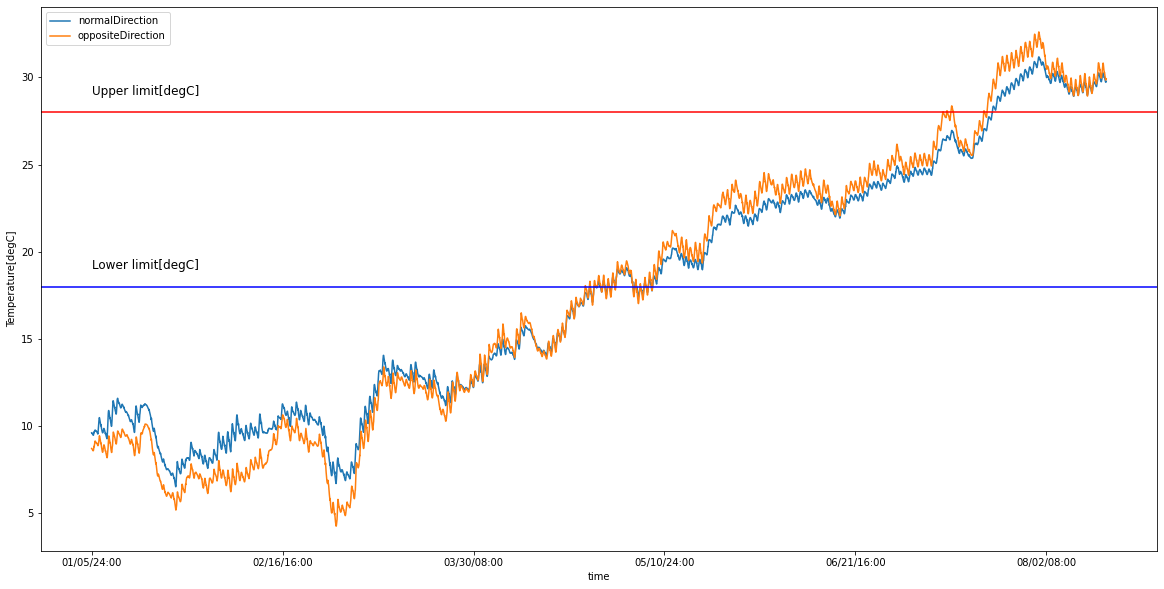

In [192]:
plotDf(test,"01/01/10:00","08/15/10:00")

<a id='section_4'></a>
# Tutorial5. 換気回数を変更してみる

In [28]:
t4List = getResultData(17)
t4df=dataFrameByKey(t4List,"temp")

In [193]:
t5List = getResultData(18)
t5df=dataFrameByKey(t5List,"temp")

In [194]:
test = pd.DataFrame([t4df["room1"],t5df["room1"]]).T
test.columns=["ach0.5","ach1"]

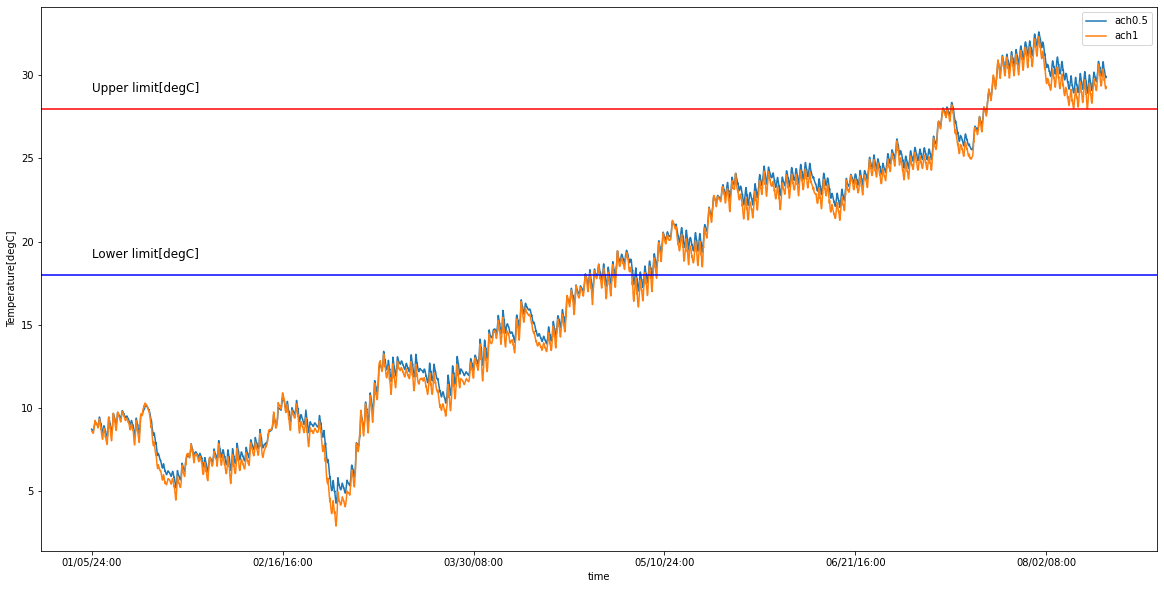

In [196]:
plotDf(test,"01/01/10:00","08/15/10:00")

<a id='section_6'></a>
# Tutorial6. 壁体構成を変更してみる

In [218]:
t6List = getResultData(15)
t6df=dataFrameByKey(t6List,"sensibleLoad")

In [222]:
t6df

,room1,total,AC
time,,,
01/05/24:00,0.0,0.0,heating
01/06/01:00,0.0,0.0,heating
01/06/02:00,0.0,0.0,heating
01/06/03:00,0.0,0.0,heating
01/06/04:00,0.0,0.0,heating
...,...,...,...
12/26/20:00,0.0,0.0,heating
12/26/21:00,0.0,0.0,heating
12/26/22:00,0.0,0.0,heating


In [221]:
calcLoad(t6df)

KeyError: 'cooling'

<a id='section_7'></a>
# Tutorial7. 空調負荷を計算してみる

In [198]:
t7List = getResultData(16)
t7df=dataFrameByKey(t7List,"sensibleLoad")

<AxesSubplot:xlabel='time'>

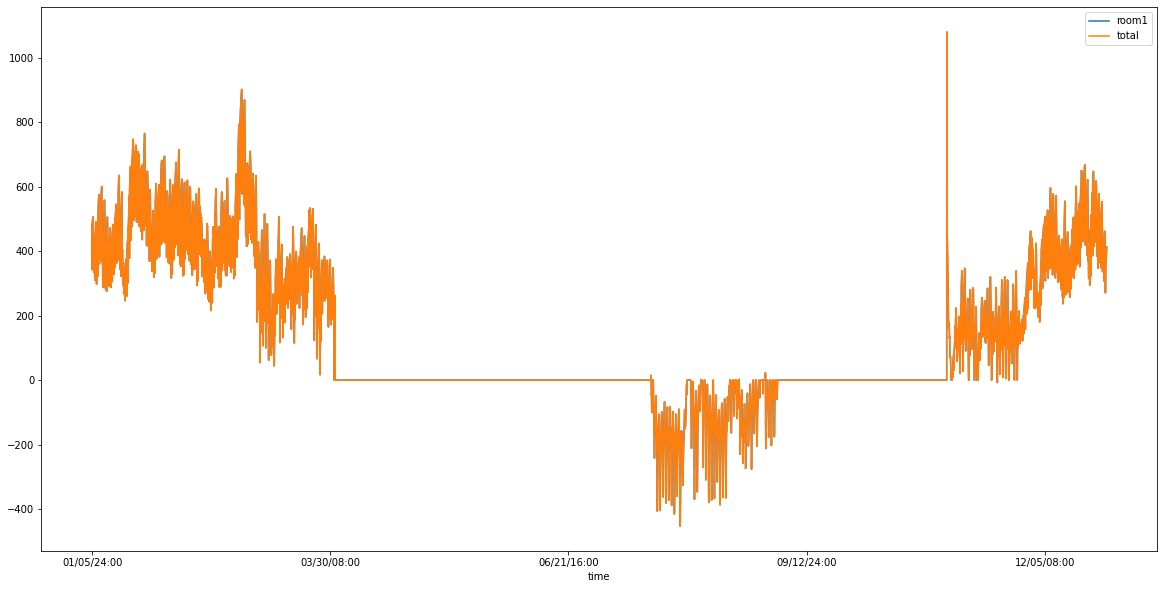

In [206]:
t7df.plot(figsize=(20,10))

## 暖房、冷房負荷を集計してみる

In [220]:
def calcLoad(loadDf):
    def checkAC(value):
        if value >=0:
            return "heating"
        else:
            return "cooling"

    loadDf["total"]=loadDf.sum(axis=1)
    loadDf["AC"]=loadDf["total"].apply(checkAC)

    grouped = loadDf.groupby("AC").sum()
    cooling=grouped["total"]["cooling"]
    heating=grouped["total"]["heating"]

    return{
        "coolingLoad":-cooling,
        "heatingLoad":heating,
        "totalLoad":heating-cooling
    }

In [ ]:
calcLoad()

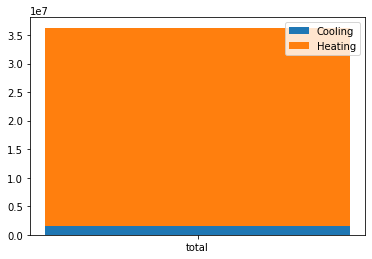

In [35]:
labels=["total"]
cooling=[-t6df.groupby("AC").sum()["total"]["cooling"]]
heating=[t6df.groupby("AC").sum()["total"]["heating"]]
fig, ax = plt.subplots()

width = 0.35
ax.bar(labels, cooling, width,  label='Cooling')
ax.bar(labels, heating, width,  bottom=cooling,
       label='Heating')
ax.legend()

In [40]:
def plotLoad(loadDf):
    def checkAC(value):
        if value >=0:
            return "heating"
        else:
            return "cooling"
    loadDf["total"]=loadDf.sum(axis=1)
    loadDf["AC"]=loadDf["total"].apply(checkAC)
    
    #groupby
    grouped = loadDf.groupby("AC").sum()
    labels=grouped.columns
    cooling=grouped.loc["cooling"].tolist()
    heating=grouped.loc["heating"].tolist()
    fig, ax = plt.subplots()

    width = 0.35
    ax.bar(labels, cooling, width,  label='Cooling')
    ax.bar(labels, heating, width,  bottom=cooling,
           label='Heating')
    ax.legend()

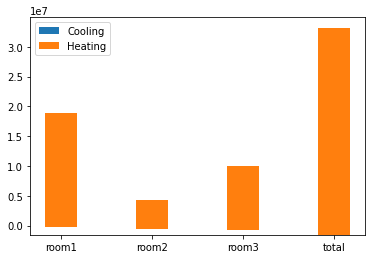

In [42]:
plotLoad(t6df)

In [12]:
plotDf(t5df,"01/01/10:00","01/15/10:00")

NameError: name 'plotDf' is not defined

In [21]:
df=convertToDataframe(t4List)

AttributeError: 'list' object has no attribute 'items'

<AxesSubplot:xlabel='time'>

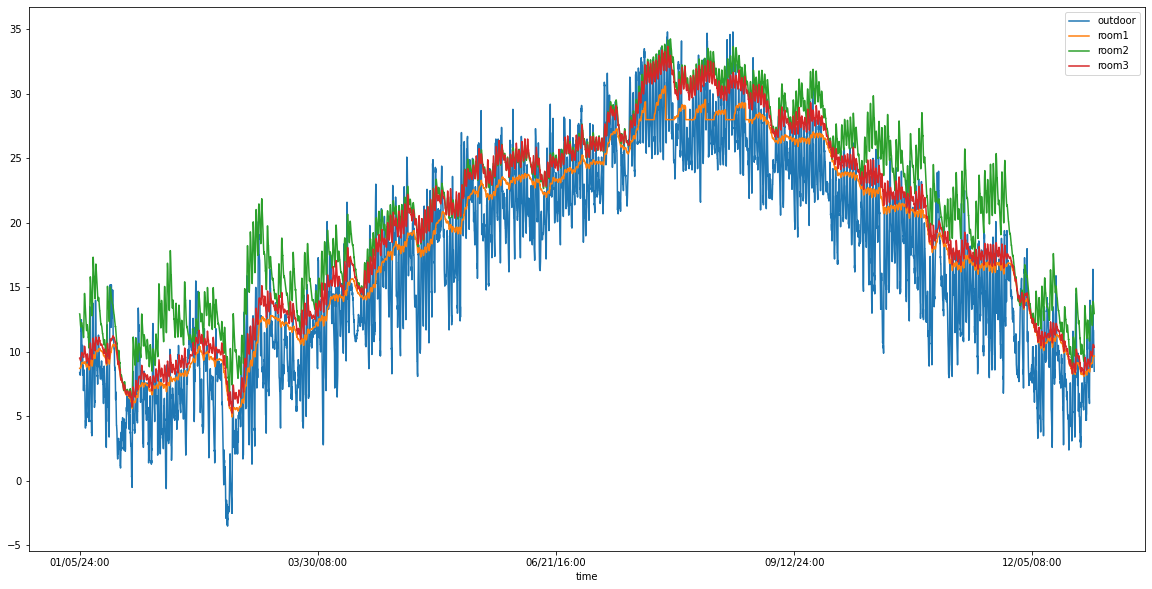

In [17]:
t4df.plot(figsize=(20,10))

In [107]:
def makeWeeklyChart(seriesData):
    test=[]
    for i in range(50):
        temp=seriesData[24*7*i+1:24*7*i+24*7+1]
        temp.index=range(1,24*7+1)
        test.append(temp)
    df=pd.concat(test,axis=1,ignore_index=True)
    return df

In [109]:
outdoorWeekly=makeWeeklyChart(df["outdoor"])

0 1 169
1 169 337
2 337 505
3 505 673
4 673 841
5 841 1009
6 1009 1177
7 1177 1345
8 1345 1513
9 1513 1681
10 1681 1849
11 1849 2017
12 2017 2185
13 2185 2353
14 2353 2521
15 2521 2689
16 2689 2857
17 2857 3025
18 3025 3193
19 3193 3361
20 3361 3529
21 3529 3697
22 3697 3865
23 3865 4033
24 4033 4201
25 4201 4369
26 4369 4537
27 4537 4705
28 4705 4873
29 4873 5041
30 5041 5209
31 5209 5377
32 5377 5545
33 5545 5713
34 5713 5881
35 5881 6049
36 6049 6217
37 6217 6385
38 6385 6553
39 6553 6721
40 6721 6889
41 6889 7057
42 7057 7225
43 7225 7393
44 7393 7561
45 7561 7729
46 7729 7897
47 7897 8065
48 8065 8233
49 8233 8401


<AxesSubplot:>

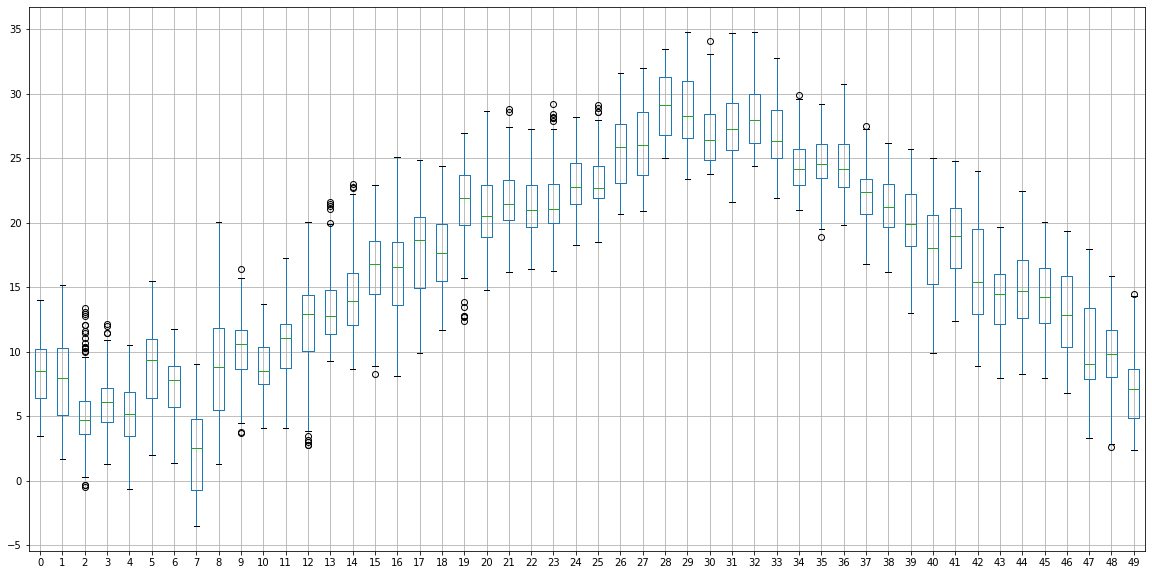

In [110]:
outdoorWeekly.boxplot(figsize=(20,10))

<AxesSubplot:>

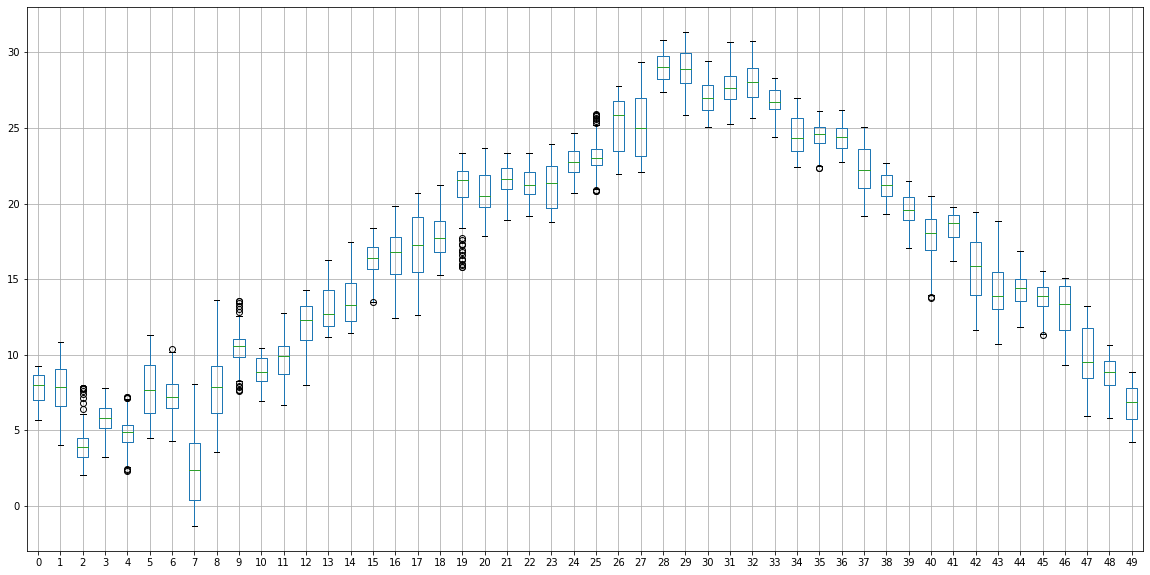

In [106]:
weekly.boxplot(figsize=(20,10))

In [85]:
def makeDailyChart(df):
    test=[]
    for i in range(360):
        temp=df["room1"][24*i+1:24*i+25]
        temp.index=range(1,25)
        print(temp)
        test.append(temp)
    return test

In [86]:
test=makeDailyChart(df)

1     7.51
2     7.47
3     7.43
4     7.39
5     7.35
6     7.32
7     7.29
8     7.27
9     7.27
10    7.33
11    7.46
12    7.65
13    7.76
14    8.01
15    8.25
16    8.45
17    8.63
18    8.77
19    8.87
20    8.89
21    8.87
22    8.82
23    8.77
24    8.73
Name: room1, dtype: float32
1     8.67
2     8.64
3     8.60
4     8.52
5     8.44
6     8.35
7     8.25
8     8.12
9     8.01
10    7.95
11    7.96
12    8.02
13    8.11
14    8.21
15    8.30
16    8.38
17    8.43
18    8.41
19    8.34
20    8.22
21    8.06
22    7.88
23    7.68
24    7.45
Name: room1, dtype: float32
1     7.29
2     7.03
3     6.80
4     6.59
5     6.41
6     6.24
7     6.09
8     5.96
9     5.86
10    5.81
11    5.83
12    5.93
13    6.03
14    6.26
15    6.51
16    6.76
17    6.97
18    7.11
19    7.19
20    7.21
21    7.18
22    7.09
23    6.97
24    6.81
Name: room1, dtype: float32
1     6.68
2     6.50
3     6.33
4     6.18
5     6.05
6     5.93
7     5.81
8     5.70
9     5.65
10    5.71
11    5.92
12 

1     7.84
2     7.64
3     7.44
4     7.21
5     6.96
6     6.70
7     6.43
8     6.19
9     6.04
10    6.05
11    6.21
12    6.49
13    6.71
14    7.07
15    7.38
16    7.64
17    7.80
18    7.86
19    7.87
20    7.83
21    7.75
22    7.66
23    7.57
24    7.48
Name: room1, dtype: float32
1     7.40
2     7.34
3     7.30
4     7.26
5     7.23
6     7.19
7     7.15
8     7.10
9     7.03
10    6.96
11    6.90
12    6.87
13    6.88
14    6.90
15    6.89
16    6.85
17    6.77
18    6.67
19    6.53
20    6.39
21    6.24
22    6.11
23    5.98
24    5.85
Name: room1, dtype: float32
1     5.75
2     5.58
3     5.39
4     5.20
5     5.03
6     4.90
7     4.81
8     4.75
9     4.72
10    4.70
11    4.69
12    4.72
13    4.77
14    4.92
15    5.11
16    5.31
17    5.48
18    5.58
19    5.62
20    5.59
21    5.52
22    5.42
23    5.31
24    5.20
Name: room1, dtype: float32
1     5.11
2     5.00
3     4.89
4     4.76
5     4.64
6     4.51
7     4.40
8     4.30
9     4.24
10    4.25
11    4.39
12 

In [90]:
daily=pd.concat(test,axis=1,ignore_index=True)

In [91]:
daily

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
1,7.51,8.67,7.29,6.68,7.90,8.53,8.87,8.83,8.00,7.13,...,5.98,5.63,6.57,7.15,8.45,9.60,8.55,8.15,7.56,10.47
2,7.47,8.64,7.03,6.50,7.58,8.31,8.78,8.74,7.95,6.97,...,5.78,5.61,6.41,7.04,8.38,9.43,8.34,7.86,7.30,10.63
3,7.43,8.60,6.80,6.33,7.27,8.07,8.69,8.66,7.89,6.79,...,5.59,5.58,6.24,6.93,8.33,9.27,8.17,7.57,7.07,10.75
4,7.39,8.52,6.59,6.18,6.96,7.84,8.60,8.57,7.82,6.57,...,5.41,5.54,6.06,6.81,8.29,9.13,8.03,7.28,6.84,10.82
5,7.35,8.44,6.41,6.05,6.67,7.62,8.50,8.49,7.75,6.34,...,5.24,5.49,5.90,6.70,8.24,9.00,7.91,6.99,6.63,10.86
6,7.32,8.35,6.24,5.93,6.40,7.41,8.41,8.41,7.67,6.09,...,5.07,5.45,5.75,6.59,8.19,8.89,7.82,6.72,6.45,10.87
7,7.29,8.25,6.09,5.81,6.14,7.22,8.31,8.33,7.57,5.84,...,4.92,5.39,5.62,6.48,8.15,8.80,7.74,6.47,6.30,10.88
8,7.27,8.12,5.96,5.70,5.94,7.05,8.22,8.25,7.46,5.60,...,4.78,5.34,5.51,6.37,8.13,8.72,7.68,6.26,6.22,10.85
9,7.27,8.01,5.86,5.65,5.83,6.95,8.15,8.19,7.35,5.43,...,4.67,5.32,5.45,6.30,8.16,8.66,7.66,6.13,6.21,10.79
10,7.33,7.95,5.81,5.71,5.87,6.96,8.13,8.15,7.26,5.40,...,4.59,5.35,5.46,6.30,8.27,8.64,7.72,6.12,6.35,10.70


<AxesSubplot:>

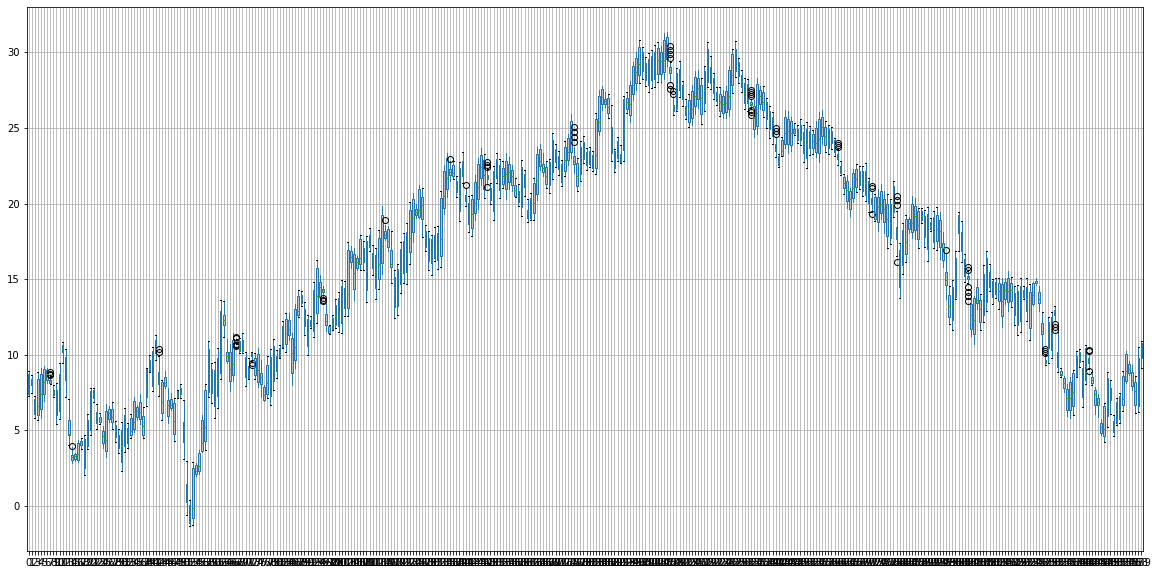

In [93]:
daily.boxplot(figsize=(20,10))

In [36]:
df["room1"]

time
01/05/24:00    7.59
01/06/01:00    7.51
01/06/02:00    7.47
01/06/03:00    7.43
01/06/04:00    7.39
               ... 
12/31/20:00    9.57
12/31/21:00    9.46
12/31/22:00    9.34
12/31/23:00    9.22
12/31/24:00    9.11
Name: room1, Length: 8641, dtype: float32

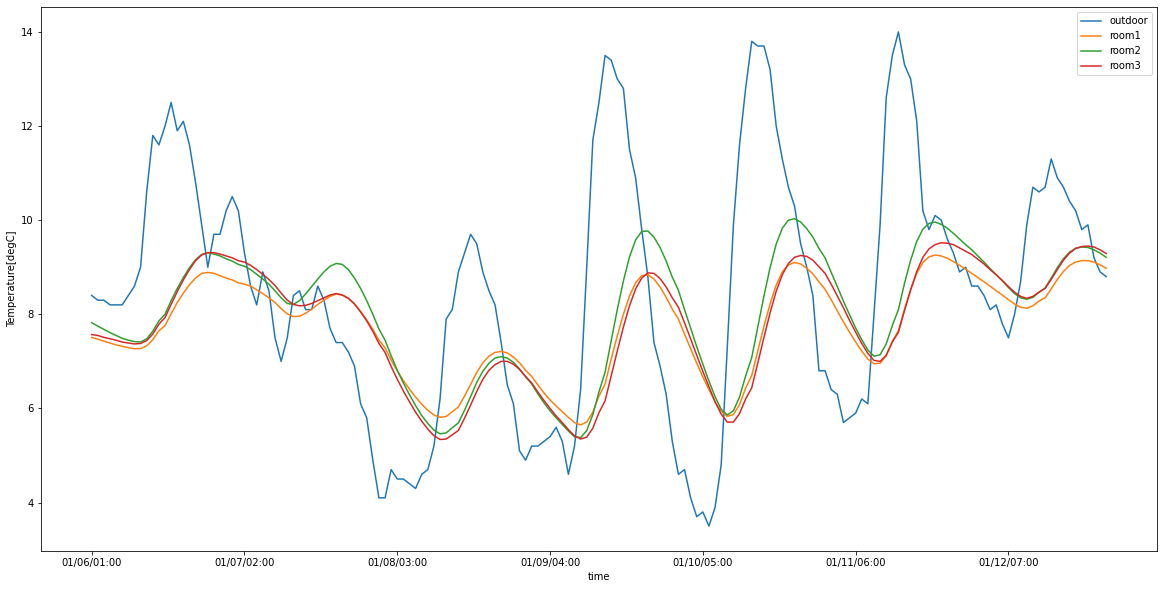

In [8]:
compareDataPlot(threeZoneList,"temp")

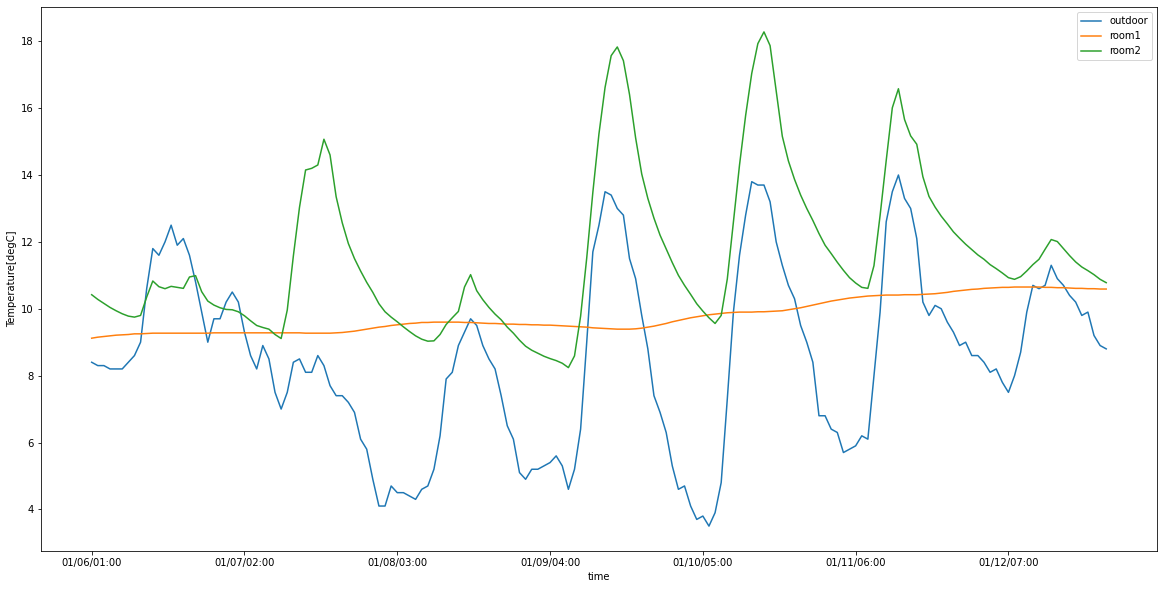

In [31]:
compareDataPlot(resultDataList,"temp")

In [22]:
tempDf=pd.concat(tempData,axis=1)
tempDf.columns = columns

Text(0, 0.5, 'Temperature')

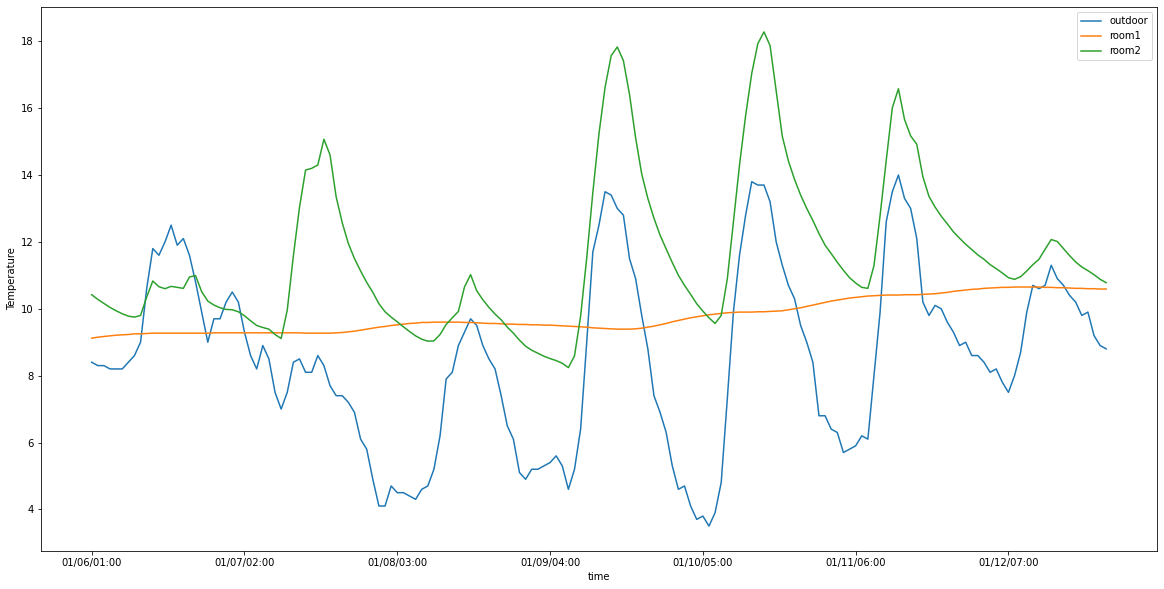

In [26]:
ax=tempDf[1:168].plot(figsize=(20,10))
ax.set_ylabel("Temperature[degC]")

## とりあえず折れ線グラフで可視化してみる

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

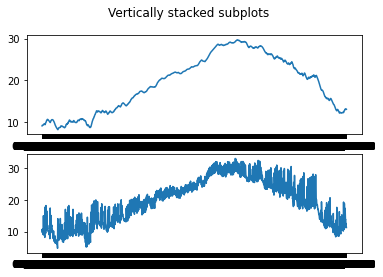

In [24]:
fig, axs = plt.subplots(1)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(df_room1.index,df_room1["temp"])
axs[0].plot(df_room2.index,df_room2["temp"])
plt.savefig('test.png')

In [ ]:
def drawLineChart(resultData):
    for resultData in resultDataList:
        

### データをすぐに確認するのはpandasのほうが早い

<AxesSubplot:xlabel='time'>

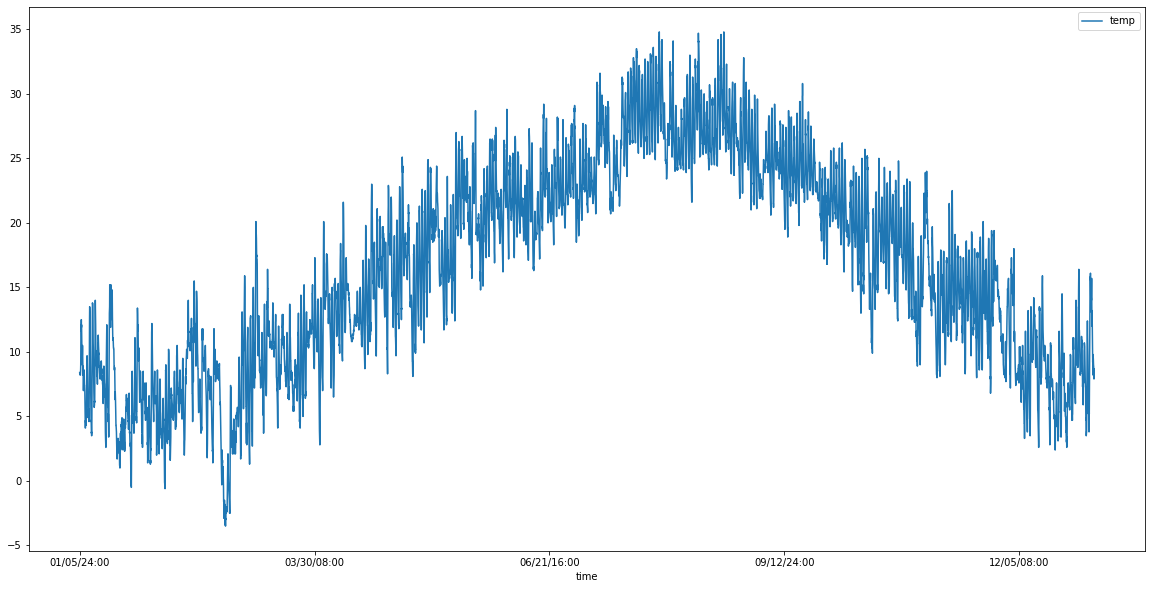

In [19]:
df_outdoor[['temp']].plot.line(figsize=(20,10))

<AxesSubplot:xlabel='time'>

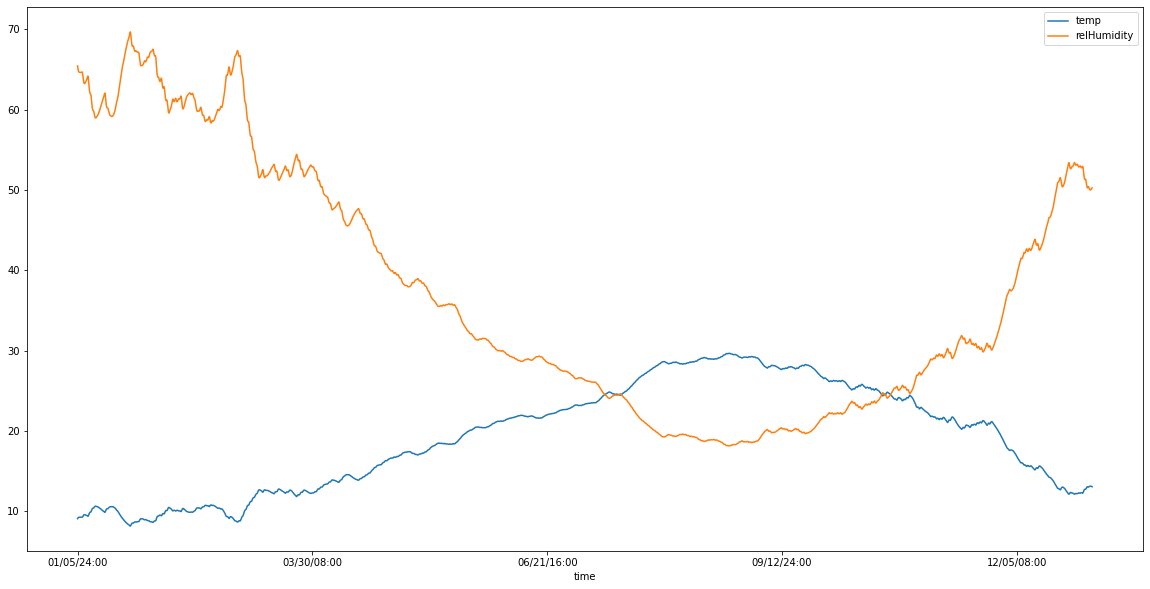

In [14]:
df_room1[['temp','relHumidity']].plot.line(figsize=(20,10))

<AxesSubplot:xlabel='time'>

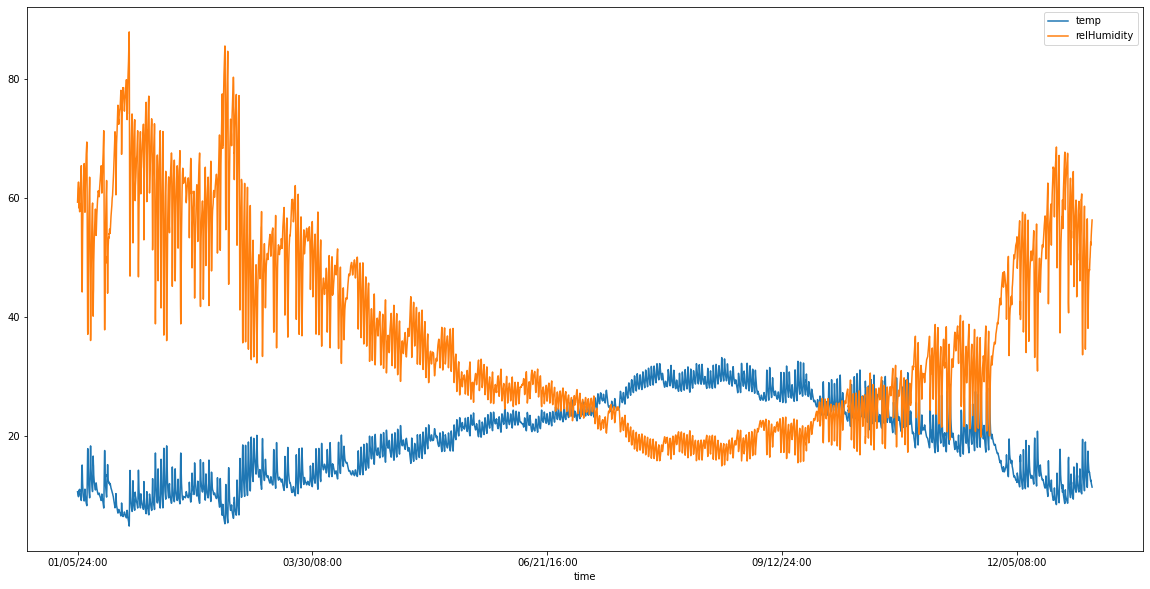

In [17]:
df_room2[['temp','relHumidity']].plot.line(figsize=(20,10))

どの温度の時間帯が多いか？

<AxesSubplot:xlabel='hour'>

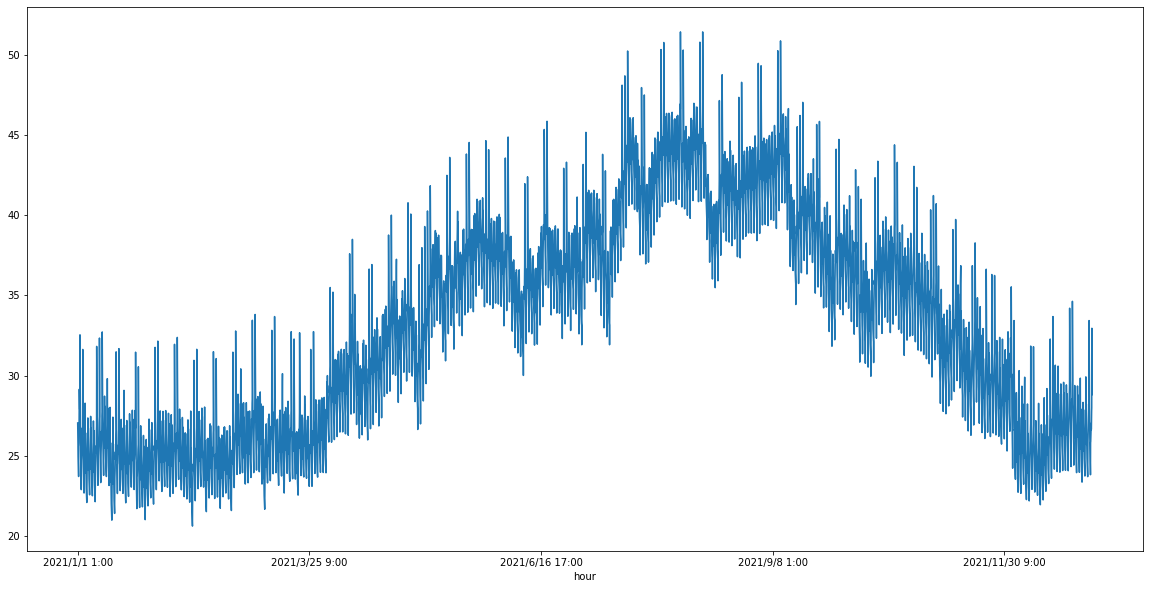

In [40]:
df_room2['roomT'].plot.line(figsize=(20,10))

<AxesSubplot:>

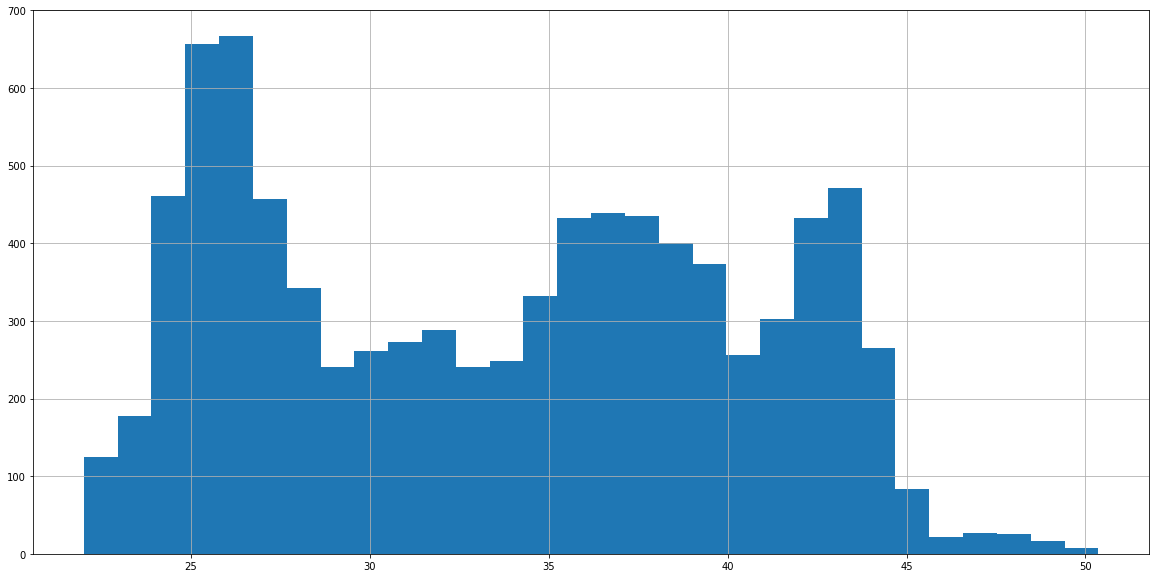

In [42]:
df_room1['roomT'].hist(figsize=(20,10),bins=30)

### 快適時間帯の割合は？

In [43]:
def calcPercentage(data,min,max):
    maxSatisfied = data[lambda x: x<max]
    satisfied = maxSatisfied[lambda x: x>min]
    percentage = len(satisfied)/len(data)*100
    return round(percentage,1)

In [44]:
calcPercentage(df_room1['roomT'],20,28)

30.5

In [45]:
calcPercentage(df_room2['roomT'],20,28)

31.3

In [46]:
calcPercentage(df_room3['roomT'],20,28)

66.0

### visualizeの見栄えをよくする

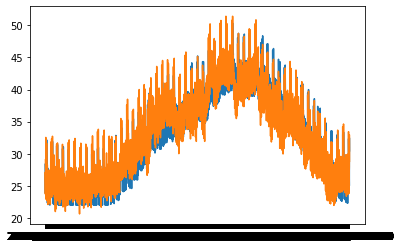

In [33]:
plt.plot(df_room1.index,df_room1['roomT'],label = "room1")
plt.plot(df_room2.index,df_room2['roomT'],label = "room2")

#### Seabornは時間がかかりすぎ

<AxesSubplot:xlabel='hour', ylabel='roomT'>

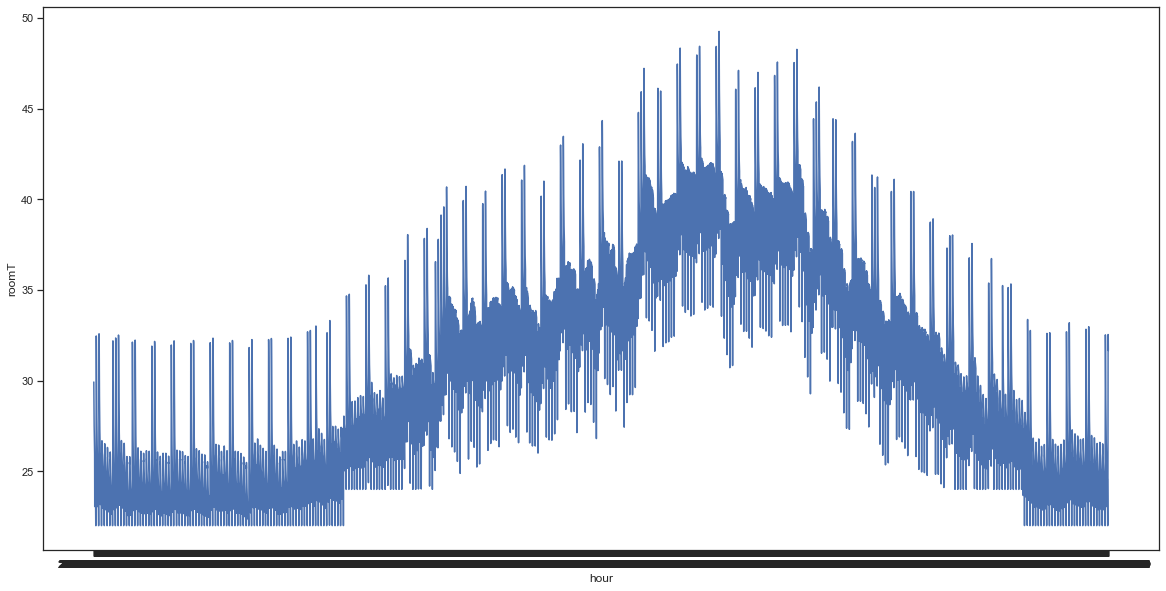

In [104]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x="hour", y="roomT")